In [62]:
import re
import collections
import tensorflow as tf
from d2l import tensorflow as d2l
import matplotlib.pyplot as plt
import numpy as np
import time

file_path = "/content/pride_and_prejudice_jane_austen.txt"
with open(file_path, 'r') as f:
    file_contents = f.read()

print(file_contents[:60])
preproccesed_text = re.sub('[^A-Za-z]+', ' ', file_contents).lower()
print(preproccesed_text[:60])

tokens = list(preproccesed_text)
','.join(tokens[:30])

﻿The Project Gutenberg eBook of Pride and Prejudice
    
Thi
 the project gutenberg ebook of pride and prejudice this ebo


' ,t,h,e, ,p,r,o,j,e,c,t, ,g,u,t,e,n,b,e,r,g, ,e,b,o,o,k, ,o'

This code below is from d2l book

In [63]:
class Vocab:

    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        # Flatten a 2D list if needed
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        # Count token frequencies
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        # The list of unique tokens
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [
            token for token, freq in self.token_freqs if freq >= min_freq])))
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]

    @property
    def unk(self):  # Index for the unknown token
        return self.token_to_idx['<unk>']

here we are creating a corpus using vocab class from d2l

In [64]:
vocab = Vocab(tokens)
indices = vocab[tokens[:10]]
print('indices:', indices)
print('words:', vocab.to_tokens(indices))
print(len(vocab))
corpus = [vocab[token] for token in tokens]

indices: [0, 21, 9, 6, 0, 17, 19, 16, 11, 6]
words: [' ', 't', 'h', 'e', ' ', 'p', 'r', 'o', 'j', 'e']
28


I slightly rewrited the TimeMachine class from d2l module

In [65]:
class Data_creator(d2l.DataModule):
    def build(self, tokens, vocab=None):
      tokens = tokens
      if vocab is None: vocab = Vocab(tokens)
      corpus = [vocab[token] for token in tokens]
      return corpus, vocab


@d2l.add_to_class(Data_creator)
def __init__(self, batch_size, num_steps,tokens, num_train=10000, num_val=5000):
    super(Data_creator, self).__init__()
    self.save_hyperparameters()
    corpus, self.vocab = self.build(tokens)
    array = tf.constant([corpus[i:i+num_steps+1]
                        for i in range(len(corpus)-num_steps)])
    self.X, self.Y = array[:,:-1], array[:,1:]

@d2l.add_to_class(Data_creator)
def get_dataloader(self, train):
    idx = slice(0, self.num_train) if train else slice(
        self.num_train, self.num_train + self.num_val)
    return self.get_tensorloader([self.X, self.Y], train, idx)


In [66]:
data = Data_creator(batch_size=1024, num_steps=32, tokens = tokens)

In [67]:
class SimpleRNNModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, num_units):
        super(SimpleRNNModel, self).__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.rnn = tf.keras.layers.SimpleRNN(num_units, return_sequences=True)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs):
        x = self.embedding(inputs)
        x = self.rnn(x)
        x = self.dense(x)
        return x

def calculate_perplexity(cross_entropy):
    return np.exp(cross_entropy)

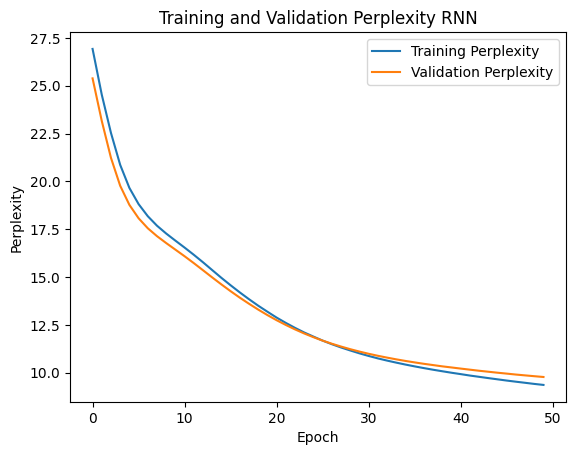

In [68]:
perplexity_values = []
test_perplexity_values = []

model = SimpleRNNModel(len(data.vocab), len(data.vocab),16)

# Adam optimizer and cross entropy as loss. Perplexity is just exp of cross entropy, so it's fine to use cross entropy
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss_function)


data_creator = Data_creator(batch_size=1024, num_steps=32, tokens=tokens)

num_epochs = 50

start_time_rnn = time.time()

for epoch in range(num_epochs):
    total_loss = 0.0
    total_batches = 0
    total_validation_loss = 0.0
    total_validation_batches = 0
    for batch_x, batch_y in data_creator.get_dataloader(train=True):
        with tf.GradientTape() as tape:
            # Forward pass
            predictions = model(batch_x, training=True)
            # Compute the loss
            loss = loss_function(batch_y, predictions)

        # Backpropagation
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        total_loss += loss
        total_batches += 1



    for batch_x, batch_y in data_creator.get_dataloader(train=False):
        # Forward pass for validation data
        validation_predictions = model(batch_x, training=False)
        # Compute the validation loss
        validation_loss = loss_function(batch_y, validation_predictions)
        total_validation_loss += validation_loss
        total_validation_batches += 1


    average_loss = total_loss / total_batches
    perplexity = calculate_perplexity(average_loss)
    perplexity_values.append(perplexity)


    average_validation_loss = total_validation_loss / total_validation_batches
    validation_perplexity = calculate_perplexity(average_validation_loss)
    test_perplexity_values.append(validation_perplexity)

end_time_rnn = time.time()
training_time_rnn = end_time_rnn - start_time_rnn

plt.plot(perplexity_values, label="Training Perplexity")
plt.plot(test_perplexity_values, label="Validation Perplexity")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.legend()
plt.title("Training and Validation Perplexity RNN")
plt.show()






# Task 2

In [69]:
class LSTMModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, num_units):
        super(LSTMModel, self).__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.LSTM(num_units, return_sequences=True)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs):
        x = self.embedding(inputs)
        x = self.lstm(x)
        x = self.dense(x)
        return x

def calculate_perplexity(cross_entropy):
    return np.exp(cross_entropy)

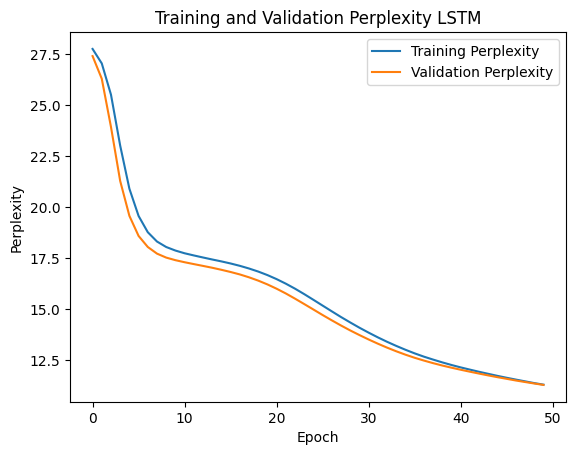

In [70]:
perplexity_values_lstm = []
test_perplexity_values_lstm = []

model_lstm = LSTMModel(len(data.vocab), len(data.vocab),16)

# Adam optimizer and cross entropy as loss. Perplexity is just exp of cross entropy, so it's fine to use cross entropy
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model_lstm.compile(optimizer=optimizer, loss=loss_function)


data_creator = Data_creator(batch_size=1024, num_steps=32, tokens=tokens)

num_epochs = 50

start_time_lstm = time.time()

for epoch in range(num_epochs):
    total_loss = 0.0
    total_batches = 0
    total_validation_loss = 0.0
    total_validation_batches = 0
    for batch_x, batch_y in data_creator.get_dataloader(train=True):
        with tf.GradientTape() as tape:
            # Forward pass
            predictions = model_lstm(batch_x, training=True)
            # Compute the loss
            loss = loss_function(batch_y, predictions)

        # Backpropagation
        gradients = tape.gradient(loss, model_lstm.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model_lstm.trainable_variables))
        total_loss += loss
        total_batches += 1



    for batch_x, batch_y in data_creator.get_dataloader(train=False):
        # Forward pass for validation data
        validation_predictions = model_lstm(batch_x, training=False)
        # Compute the validation loss
        validation_loss = loss_function(batch_y, validation_predictions)
        total_validation_loss += validation_loss
        total_validation_batches += 1


    average_loss = total_loss / total_batches
    perplexity = calculate_perplexity(average_loss)
    perplexity_values_lstm.append(perplexity)


    average_validation_loss = total_validation_loss / total_validation_batches
    validation_perplexity = calculate_perplexity(average_validation_loss)
    test_perplexity_values_lstm.append(validation_perplexity)

end_time_lstm = time.time()
training_time_lstm = end_time_lstm - start_time_lstm

plt.plot(perplexity_values_lstm, label="Training Perplexity")
plt.plot(test_perplexity_values_lstm, label="Validation Perplexity")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.legend()
plt.title("Training and Validation Perplexity LSTM")
plt.show()






In [71]:
class GRUModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, num_units):
        super(GRUModel, self).__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(num_units, return_sequences=True)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs):
        x = self.embedding(inputs)
        x = self.gru(x)
        x = self.dense(x)
        return x

def calculate_perplexity(cross_entropy):
    return np.exp(cross_entropy)

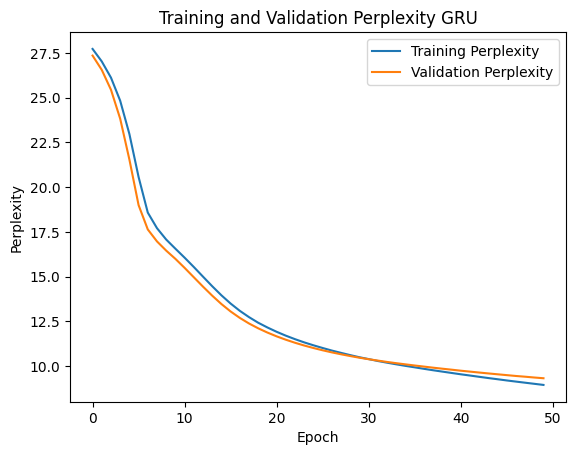

In [72]:
perplexity_values_gru = []
test_perplexity_values_gru = []

model_gru = GRUModel(len(data.vocab), len(data.vocab),16)

# Adam optimizer and cross entropy as loss. Perplexity is just exp of cross entropy, so it's fine to use cross entropy
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model_gru.compile(optimizer=optimizer, loss=loss_function)


data_creator = Data_creator(batch_size=1024, num_steps=32, tokens=tokens)

num_epochs = 50

start_time_gru = time.time()

for epoch in range(num_epochs):
    total_loss = 0.0
    total_batches = 0
    total_validation_loss = 0.0
    total_validation_batches = 0
    for batch_x, batch_y in data_creator.get_dataloader(train=True):
        with tf.GradientTape() as tape:
            # Forward pass
            predictions = model_gru(batch_x, training=True)
            # Compute the loss
            loss = loss_function(batch_y, predictions)

        # Backpropagation
        gradients = tape.gradient(loss, model_gru.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model_gru.trainable_variables))
        total_loss += loss
        total_batches += 1



    for batch_x, batch_y in data_creator.get_dataloader(train=False):
        # Forward pass for validation data
        validation_predictions = model_gru(batch_x, training=False)
        # Compute the validation loss
        validation_loss = loss_function(batch_y, validation_predictions)
        total_validation_loss += validation_loss
        total_validation_batches += 1


    average_loss = total_loss / total_batches
    perplexity = calculate_perplexity(average_loss)
    perplexity_values_gru.append(perplexity)

    average_validation_loss = total_validation_loss / total_validation_batches
    validation_perplexity = calculate_perplexity(average_validation_loss)
    test_perplexity_values_gru.append(validation_perplexity)

end_time_gru = time.time()
training_time_gru = end_time_gru - start_time_gru

# Plot training and validation perplexity values
plt.plot(perplexity_values_gru, label="Training Perplexity")
plt.plot(test_perplexity_values_gru, label="Validation Perplexity")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.legend()
plt.title("Training and Validation Perplexity GRU")
plt.show()






# Task 3

In [73]:
seed_text = "hav"
preproccesed_text = re.sub('[^A-Za-z]+', ' ', seed_text).lower()
seed_tokens = list(preproccesed_text)
# Tokenize the seed text
seed_tokens = [vocab[token] for token in seed_tokens]

generated_text = seed_tokens.copy()  # Initialize with seed tokens

num_tokens_to_generate = 16

s_time_rnn_inference = time.time()

for _ in range(num_tokens_to_generate):

    input_sequence = np.array([generated_text])

    # Model predicts the next token
    predictions = model(input_sequence)
    predicted_token = np.argmax(predictions[0][-1])  # Get the token with the highest probability

    # Appending predicted tokens to the generated text
    generated_text.append(predicted_token)

e_time_rnn_inference = time.time()
inference_rnn = e_time_rnn_inference - s_time_rnn_inference

# Converting the generated tokens back to words
generated_text_words = [data_creator.vocab.idx_to_token[token] for token in generated_text]

generated_text_rnn = " ".join(generated_text_words)

print("Generated Text:")
print(generated_text_rnn)

Generated Text:
h a v e   t h e   t h e   t h e   t h


In [74]:
seed_text = "hav"
preproccesed_text = re.sub('[^A-Za-z]+', ' ', seed_text).lower()
seed_tokens = list(preproccesed_text)
# Tokenize the seed text
seed_tokens = [vocab[token] for token in seed_tokens]

generated_text = seed_tokens.copy()  # Initialize with seed tokens

num_tokens_to_generate = 16

s_time_lstm_inference = time.time()

for _ in range(num_tokens_to_generate):

    input_sequence = np.array([generated_text])

    # Model predicts the next token
    predictions = model_lstm(input_sequence)
    predicted_token = np.argmax(predictions[0][-1])  # Get the token with the highest probability

    # Appending predicted tokens to the generated text
    generated_text.append(predicted_token)

e_time_lstm_inference = time.time()
inference_lstm = e_time_lstm_inference - s_time_lstm_inference

# Converting the generated tokens back to words
generated_text_words = [data_creator.vocab.idx_to_token[token] for token in generated_text]

generated_text = " ".join(generated_text_words)

print("Generated Text:")
print(generated_text)

Generated Text:
h a v e   t h e   t h e   t h e   t h


In [75]:
seed_text = "hav"
preproccesed_text = re.sub('[^A-Za-z]+', ' ', seed_text).lower()
seed_tokens = list(preproccesed_text)
# Tokenize the seed text
seed_tokens = [vocab[token] for token in seed_tokens]

generated_text = seed_tokens.copy()  # Initialize with seed tokens

num_tokens_to_generate = 16

s_time_gru_inference = time.time()

for _ in range(num_tokens_to_generate):

    input_sequence = np.array([generated_text])

    # Model predicts the next token
    predictions = model_gru(input_sequence)
    predicted_token = np.argmax(predictions[0][-1])  # Get the token with the highest probability

    # Appending predicted tokens to the generated text
    generated_text.append(predicted_token)

e_time_gru_inference = time.time()
inference_gru = e_time_gru_inference - s_time_gru_inference

# Converting the generated tokens back to words
generated_text_words = [data_creator.vocab.idx_to_token[token] for token in generated_text]

generated_text_gru = " ".join(generated_text_words)

print("Generated Text:")
print(generated_text_gru)

Generated Text:
h a v e   t h e   t h e   t h e   t h


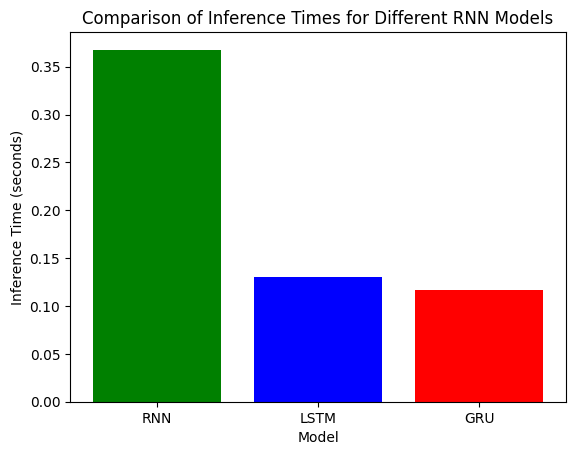

In [76]:
models = ['RNN', 'LSTM', 'GRU']
inference_times = [inference_rnn, inference_lstm, inference_gru]

# Create a bar chart
plt.bar(models, inference_times, color=['green', 'blue', 'red'])
plt.xlabel('Model')
plt.ylabel('Inference Time (seconds)')
plt.title('Comparison of Inference Times for Different RNN Models')
plt.show()

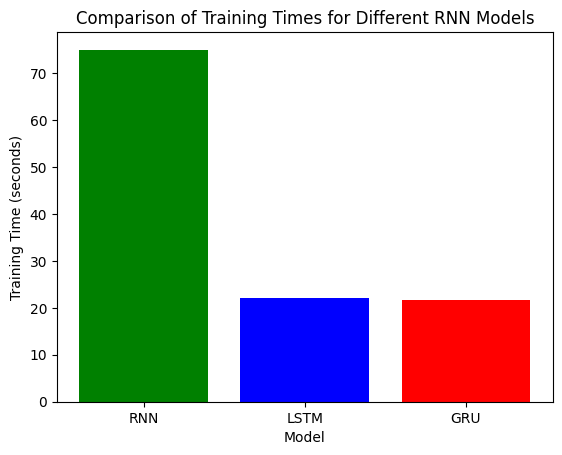

In [77]:
# List of model names and training times
models = ['RNN', 'LSTM', 'GRU']
training_times = [training_time_rnn, training_time_lstm, training_time_gru]

# Create a bar chart
plt.bar(models, training_times, color=['green', 'blue', 'red'])
plt.xlabel('Model')
plt.ylabel('Training Time (seconds)')
plt.title('Comparison of Training Times for Different RNN Models')
plt.show()

In inference time GRU outperforms both models. In training time simple RNN is significantly slower, while GRU is slightly faster than LSTM. Overall GRU shows better results, then LSTM then the simple RNN

# Task 4

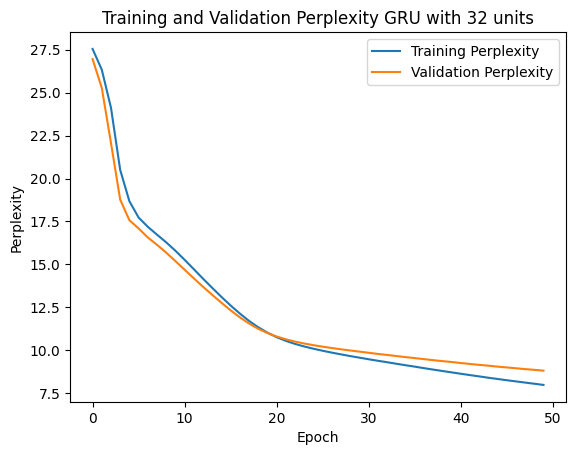

In [78]:
perplexity_values_gru_32 = []
test_perplexity_values_gru_32 = []

model_gru_32 = GRUModel(len(data.vocab), len(data.vocab),32)

# Adam optimizer and cross entropy as loss. Perplexity is just exp of cross entropy, so it's fine to use cross entropy
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model_gru_32.compile(optimizer=optimizer, loss=loss_function)


data_creator = Data_creator(batch_size=1024, num_steps=32, tokens=tokens)

num_epochs = 50

start_time_gru_32 = time.time()

for epoch in range(num_epochs):
    total_loss = 0.0
    total_batches = 0
    total_validation_loss = 0.0
    total_validation_batches = 0
    for batch_x, batch_y in data_creator.get_dataloader(train=True):
        with tf.GradientTape() as tape:
            # Forward pass
            predictions = model_gru_32(batch_x, training=True)
            # Compute the loss
            loss = loss_function(batch_y, predictions)

        # Backpropagation
        gradients = tape.gradient(loss, model_gru_32.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model_gru_32.trainable_variables))
        total_loss += loss
        total_batches += 1



    for batch_x, batch_y in data_creator.get_dataloader(train=False):
        # Forward pass for validation data
        validation_predictions = model_gru_32(batch_x, training=False)
        # Compute the validation loss
        validation_loss = loss_function(batch_y, validation_predictions)
        total_validation_loss += validation_loss
        total_validation_batches += 1


    average_loss = total_loss / total_batches
    perplexity = calculate_perplexity(average_loss)
    perplexity_values_gru_32.append(perplexity)

    average_validation_loss = total_validation_loss / total_validation_batches
    validation_perplexity = calculate_perplexity(average_validation_loss)
    test_perplexity_values_gru_32.append(validation_perplexity)

end_time_gru_32 = time.time()
training_time_gru_32 = end_time_gru_32 - start_time_gru_32

# Plot training and validation perplexity values
plt.plot(perplexity_values_gru_32, label="Training Perplexity")
plt.plot(test_perplexity_values_gru_32, label="Validation Perplexity")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.legend()
plt.title("Training and Validation Perplexity GRU with 32 units")
plt.show()

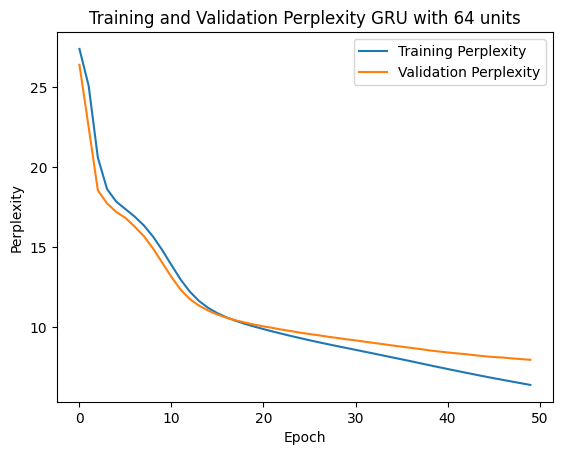

In [79]:
perplexity_values_gru_64 = []
test_perplexity_values_gru_64 = []

model_gru_64 = GRUModel(len(data.vocab), len(data.vocab),64)

# Adam optimizer and cross entropy as loss. Perplexity is just exp of cross entropy, so it's fine to use cross entropy
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model_gru_64.compile(optimizer=optimizer, loss=loss_function)


data_creator = Data_creator(batch_size=1024, num_steps=32, tokens=tokens)

num_epochs = 50

start_time_gru_64 = time.time()

for epoch in range(num_epochs):
    total_loss = 0.0
    total_batches = 0
    total_validation_loss = 0.0
    total_validation_batches = 0
    for batch_x, batch_y in data_creator.get_dataloader(train=True):
        with tf.GradientTape() as tape:
            # Forward pass
            predictions = model_gru_64(batch_x, training=True)
            # Compute the loss
            loss = loss_function(batch_y, predictions)

        # Backpropagation
        gradients = tape.gradient(loss, model_gru_64.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model_gru_64.trainable_variables))
        total_loss += loss
        total_batches += 1



    for batch_x, batch_y in data_creator.get_dataloader(train=False):
        # Forward pass for validation data
        validation_predictions = model_gru_64(batch_x, training=False)
        # Compute the validation loss
        validation_loss = loss_function(batch_y, validation_predictions)
        total_validation_loss += validation_loss
        total_validation_batches += 1


    average_loss = total_loss / total_batches
    perplexity = calculate_perplexity(average_loss)
    perplexity_values_gru_64.append(perplexity)

    average_validation_loss = total_validation_loss / total_validation_batches
    validation_perplexity = calculate_perplexity(average_validation_loss)
    test_perplexity_values_gru_64.append(validation_perplexity)

end_time_gru_64 = time.time()
training_time_gru_64 = end_time_gru_64 - start_time_gru_64

# Plot training and validation perplexity values
plt.plot(perplexity_values_gru_64, label="Training Perplexity")
plt.plot(test_perplexity_values_gru_64, label="Validation Perplexity")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.legend()
plt.title("Training and Validation Perplexity GRU with 64 units")
plt.show()

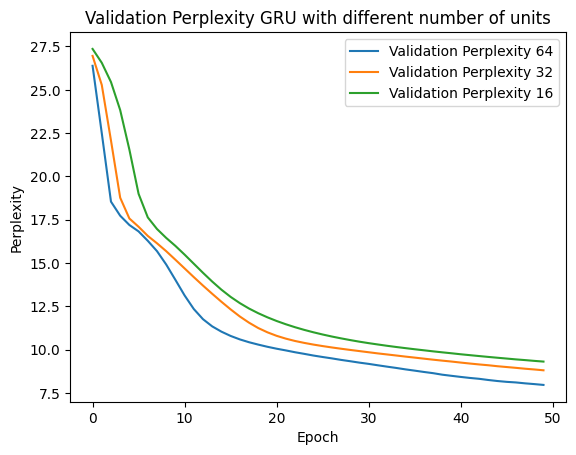

In [80]:
plt.plot(test_perplexity_values_gru_64, label="Validation Perplexity 64")
plt.plot(test_perplexity_values_gru_32, label="Validation Perplexity 32")
plt.plot(test_perplexity_values_gru, label="Validation Perplexity 16")

plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.legend()
plt.title("Validation Perplexity GRU with different number of units")
plt.show()

In [81]:
seed_text = "hav"
preproccesed_text = re.sub('[^A-Za-z]+', ' ', seed_text).lower()
seed_tokens = list(preproccesed_text)
# Tokenize the seed text
seed_tokens = [vocab[token] for token in seed_tokens]

generated_text_gru_32 = seed_tokens.copy()  # Initialize with seed tokens


num_tokens_to_generate = 16

s_time_gru_inference = time.time()

for _ in range(num_tokens_to_generate):

    input_sequence = np.array([generated_text_gru_32])

    # Model predicts the next token
    predictions = model_gru_32(input_sequence)
    predicted_token = np.argmax(predictions[0][-1])  # Get the token with the highest probability

    # Appending predicted tokens to the generated text
    generated_text_gru_32.append(predicted_token)

e_time_gru_inference = time.time()
inference_gru_32 = e_time_gru_inference - s_time_gru_inference

# Converting the generated tokens back to words
generated_text_words = [data_creator.vocab.idx_to_token[token] for token in generated_text_gru_32]

generated_text_gru_32 = " ".join(generated_text_words)

print("Generated Text:")
print(generated_text_gru_32)

Generated Text:
h a v e   a n d   t h e   a n d   t h


In [82]:
seed_text = "hav"
preproccesed_text = re.sub('[^A-Za-z]+', ' ', seed_text).lower()
seed_tokens = list(preproccesed_text)
# Tokenize the seed text
seed_tokens = [vocab[token] for token in seed_tokens]

generated_text_gru_64 = seed_tokens.copy()  # Initialize with seed tokens

num_tokens_to_generate = 16

s_time_gru_inference = time.time()

for _ in range(num_tokens_to_generate):

    input_sequence = np.array([generated_text_gru_64])

    # Model predicts the next token
    predictions = model_gru_64(input_sequence)
    predicted_token = np.argmax(predictions[0][-1])  # Get the token with the highest probability

    # Appending predicted tokens to the generated text
    generated_text_gru_64.append(predicted_token)

e_time_gru_inference = time.time()
inference_gru_64 = e_time_gru_inference - s_time_gru_inference

# Converting the generated tokens back to words
generated_text_words = [data_creator.vocab.idx_to_token[token] for token in generated_text_gru_64]

generated_text_gru_64 = " ".join(generated_text_words)

print("Generated Text:")
print(generated_text_gru_64)

Generated Text:
h a v e   t h e   m i s t e r   a n d


In [83]:
print("Text generated by GRU with 16 units:" , generated_text_gru)
print("Text generated by GRU with 32 units:" ,generated_text_gru_32)
print("Text generated by GRU with 64 units:" ,generated_text_gru_64)


Text generated by GRU with 16 units: h a v e   t h e   t h e   t h e   t h
Text generated by GRU with 32 units: h a v e   a n d   t h e   a n d   t h
Text generated by GRU with 64 units: h a v e   t h e   m i s t e r   a n d


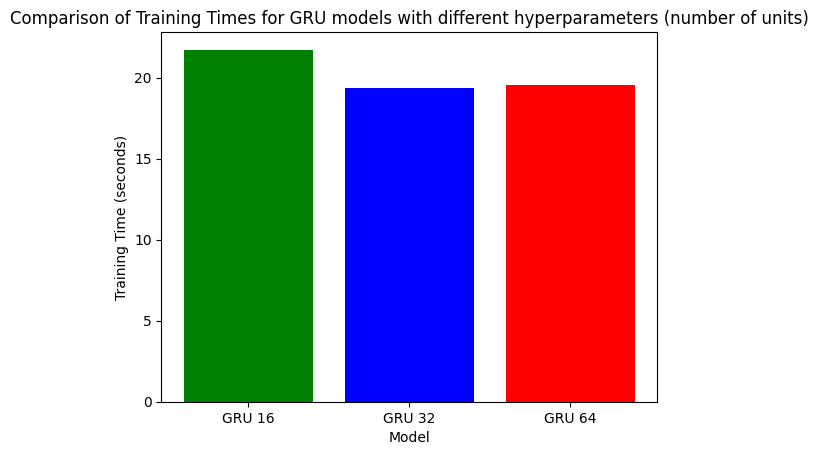

In [84]:
# List of model names and training times
models = ['GRU 16', 'GRU 32', 'GRU 64']
training_times = [training_time_gru, training_time_gru_32, training_time_gru_64]

# Create a bar chart
plt.bar(models, training_times, color=['green', 'blue', 'red'])
plt.xlabel('Model')
plt.ylabel('Training Time (seconds)')
plt.title('Comparison of Training Times for GRU models with different hyperparameters (number of units)')
plt.show()

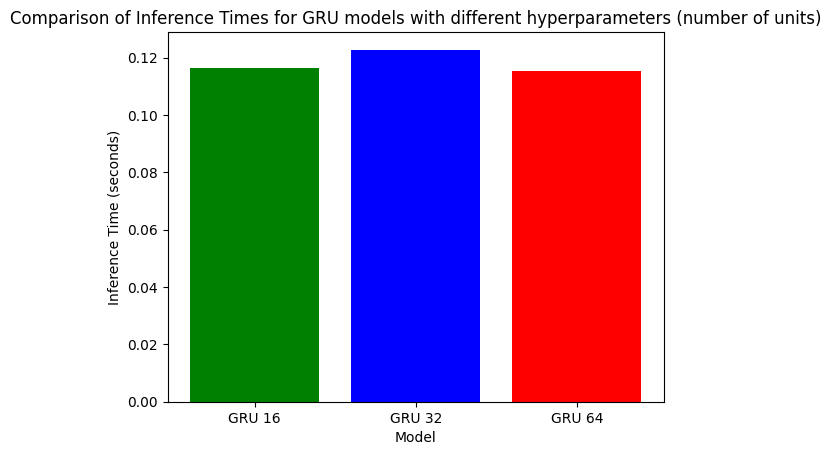

In [85]:
# List of model names and training times
models = ['GRU 16', 'GRU 32', 'GRU 64']
inference_times = [inference_gru, inference_gru_32, inference_gru_64]

# Create a bar chart
plt.bar(models, inference_times, color=['green', 'blue', 'red'])
plt.xlabel('Model')
plt.ylabel('Inference Time (seconds)')
plt.title('Comparison of Inference Times for GRU models with different hyperparameters (number of units)')
plt.show()

The GRU model with 64 units generated a reasonalbe and understandable text, while GRu with 16 units just generated "the the the" and GRU with 32 units generated "the and". The differance in cost is negligibale, while generated text have real difference. So, the GRU with 64 units is the best. Also, GRU with more units had better validation perplexity.

# Task 5

Here I compare the GRU with 16 units nd simple RNN with 16 units

In [86]:
print("Text generated by GRU with 16 units:" , generated_text_gru)
print("Text generated by simple RNN with 16 units:" ,generated_text_rnn)


Text generated by GRU with 16 units: h a v e   t h e   t h e   t h e   t h
Text generated by simple RNN with 16 units: h a v e   t h e   t h e   t h e   t h


The both text are just repetition of popular word "the"

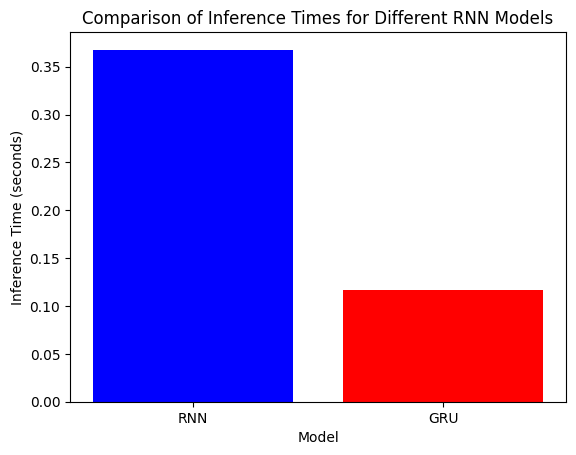

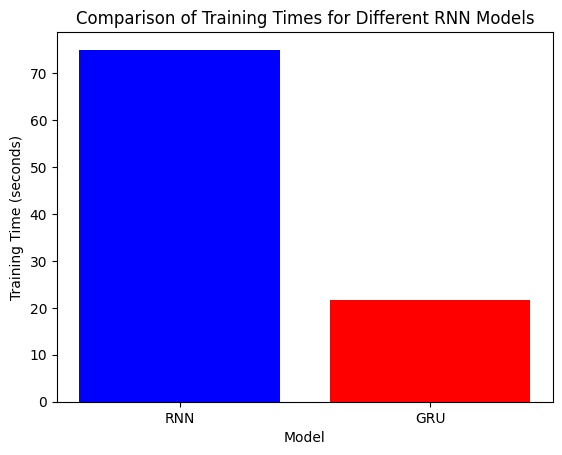

In [87]:
models_2 = ['RNN',  'GRU']
inference_times = [inference_rnn, inference_gru]

# Create a bar chart
plt.bar(models_2, inference_times, color=[ 'blue', 'red'])
plt.xlabel('Model')
plt.ylabel('Inference Time (seconds)')
plt.title('Comparison of Inference Times for Different RNN Models')
plt.show()
training_times = [training_time_rnn, training_time_gru]

# Create a bar chart
plt.bar(models_2, training_times, color=['blue', 'red'])
plt.xlabel('Model')
plt.ylabel('Training Time (seconds)')
plt.title('Comparison of Training Times for Different RNN Models')
plt.show()

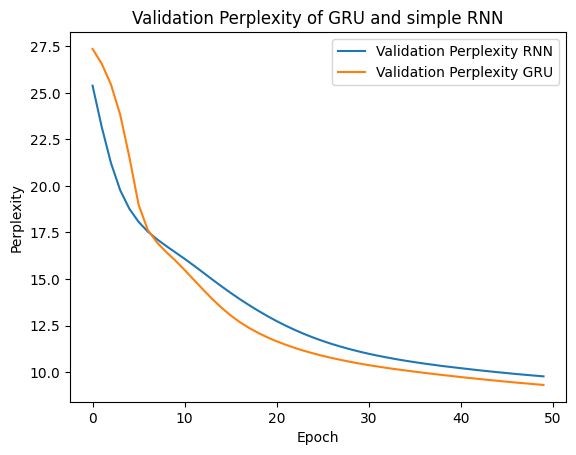

In [88]:
plt.plot(test_perplexity_values, label="Validation Perplexity RNN")
plt.plot(test_perplexity_values_gru, label="Validation Perplexity GRU")

plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.legend()
plt.title("Validation Perplexity of GRU and simple RNN")
plt.show()

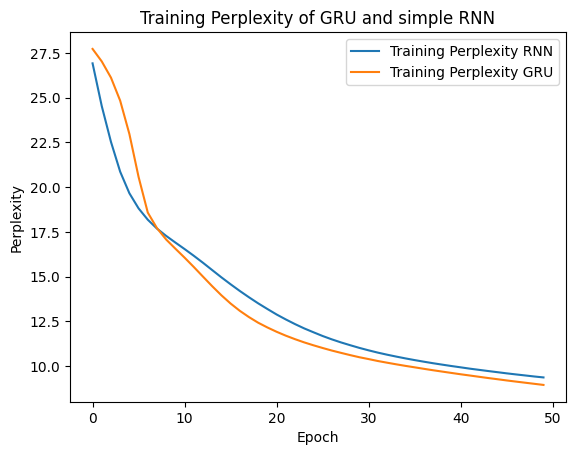

In [89]:
plt.plot(perplexity_values, label="Training Perplexity RNN")
plt.plot(perplexity_values_gru, label="Training Perplexity GRU")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.legend()
plt.title("Training Perplexity of GRU and simple RNN")
plt.show()

Overall, GRU has lesser complexity cost (around 4,5 times) than simple RNN both in training and inference cost. The generated text are similar. The perplexity values are almost the same, just a little difference in the starting epochs.